# Gépi tanulás a gyakorlatban
**Beadanód feladat**

_Sipos István_  
_F5D7DV_  
_2020.05.24_

## Osztályozás

A munkafüzet célja, hogy összehasonlítsuk a Gépi tanulás a gyakorlatban tárgyból megismert osztályozó algoritmusokat. Név szerint a lineáris regresszió, döntési fa, naív Bayes, és legközlebbi társ, mély neurális háló modelleket, az Scikit-learn könyvtár implementációit használva.

Az elemzett adatbázis: [Forest Cover Type DataSet, Kaggle](https://www.kaggle.com/uciml/forest-cover-type-dataset)

Ez a dataset a colorado-i Roosevelt Nemzeti Park flóráját vizsgálja. A megfigyeléseket 30*30 méteres területeken végezték. Az adatbázis teljes (nem tartalmaz hiányzó értékeket) és numerikus. Két kategórikus tulajdonság, a _Wilderness_Area_ és a _Soil_Type_ már one-hot kódolással van az adatbázisban tárolva, de ezeket a tulajdonságokat nem fogom használni.

A cél tulajdonságunk a Cover_type.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection as ms
from sklearn import tree
from sklearn import linear_model as lm
from sklearn import naive_bayes as nb
from sklearn import neighbors
from sklearn import neural_network as nn

Adatok betöltése

In [2]:
data = pd.read_csv("./data/covtype.csv")

felosztás tanító és teszt adatokra

In [3]:
# Input - Output
X=data.loc[:,'Elevation':'Horizontal_Distance_To_Fire_Points']
y=data['Cover_Type']

X_train, X_test, y_train, y_test = ms.train_test_split(X,y, test_size=0.1, shuffle=True, random_state=101)

#### Vizsgáljuk meg a betöltött adatokat

Vizsgáljuk meg a folytonos adatok közötti korrelációt

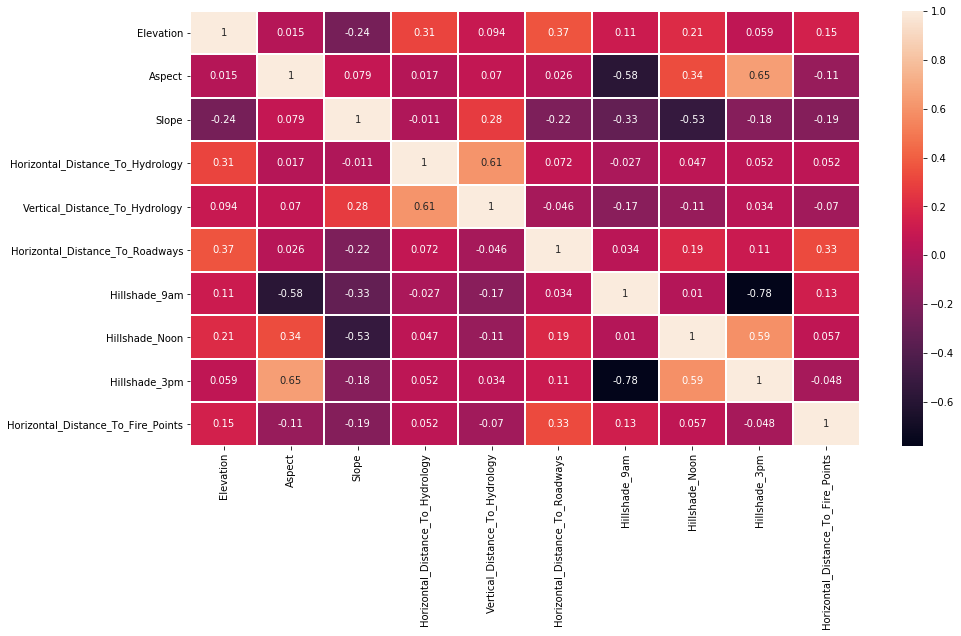

In [4]:
plt.figure(figsize=(15,8))
sns.heatmap(X_train.corr(),linecolor='white',linewidths=1,annot=True)

Látható, hogy a _Hillshade_3pm_ és _Hillshade_9am_ tulajdonságok között erös negatív korreláció van, ezért az egyiket eldobhatjuk. Hasonlóan az Aspect és Slope tulajdonságokat.

In [5]:
X_train = X_train.drop(columns=["Hillshade_3pm", "Aspect", "Slope"])
X_test = X_test.drop(columns=["Hillshade_3pm", "Aspect", "Slope"])

features = X_train.columns

**Az adatok skálázása**

In [6]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Lineáris regresszió

In [7]:
%%time
logreg_classifier = lm.LogisticRegression(multi_class='ovr', n_jobs=16)
logreg_classifier.fit(X_train,y_train)
score_logreg = logreg_classifier.score(X_test,y_test)

CPU times: user 151 ms, sys: 173 ms, total: 323 ms
Wall time: 6.32 s


#### Döntési fa

Keressünk egy megfelelö mélységet:

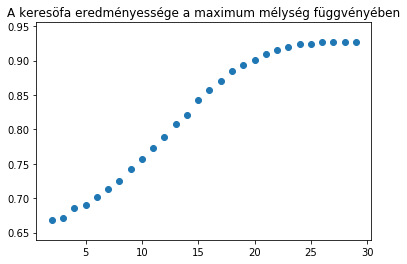

In [8]:
depth_range = range(2,30) 
scores = []
for max_depth in depth_range:
    dtree_classifier = tree.DecisionTreeClassifier(max_depth=max_depth)
    dtree_classifier.fit(X_train,y_train)
    scores.append(dtree_classifier.score(X_test,y_test))

plt.scatter(depth_range, scores)
plt.title('A keresöfa eredményessége a maximum mélység függvényében')
plt.show()

Ez alapján max_depth-nek a 22-t választom

In [9]:
%%time
dtree_classifier = tree.DecisionTreeClassifier(max_depth=22)
dtree_classifier.fit(X_train,y_train)
score_dtree = dtree_classifier.score(X_test,y_test)

CPU times: user 5.23 s, sys: 3.98 ms, total: 5.23 s
Wall time: 5.23 s


In [10]:
def display_graph():
    dot_data = tree.export_graphviz(dtree_classifier, out_file=None,
                     feature_names=features,
                     class_names=[str(n) for n in y_train.unique()],
                     filled=True, rounded=True,
                     special_characters=True)

    return graphviz.Source(dot_data)

# Nyilván a kép túl nagy, de meg lehetne jeleníteni
# display_graph()

#### Naív Bayes osztályozó

In [11]:
%%time
naive_bayes_classifier = nb.GaussianNB()
naive_bayes_classifier.fit(X_train,y_train)
score_naive_bayes = naive_bayes_classifier.score(X_test,y_test)

CPU times: user 167 ms, sys: 8.01 ms, total: 175 ms
Wall time: 174 ms


#### K legközelebbi társ osztályozó

Keressünk egy megfelelö értéket a k-nak

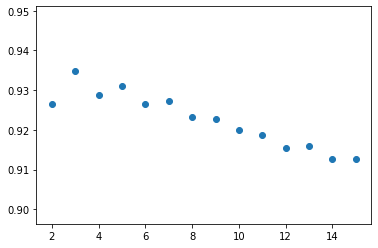

CPU times: user 2min, sys: 39.9 ms, total: 2min
Wall time: 1min 59s


In [16]:
%%time
k_range = range(2,16) 
scores = []
for k in k_range:
    knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train,y_train)
    scores.append(knn_classifier.score(X_test,y_test))

plt.scatter(k_range, scores)
plt.show()

Ez alapján K értékenek az 5-öt választom

In [17]:
%%time
K = 5
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors=K)
knn_classifier.fit(X_train,y_train)
score_knn = knn_classifier.score(X_test,y_test)

CPU times: user 7.15 s, sys: 3.99 ms, total: 7.16 s
Wall time: 7.15 s


#### Osztályozás neurális hálóval

In [18]:
%%time
neural_classifier = nn.MLPClassifier(hidden_layer_sizes=(16,6), early_stopping=True)
neural_classifier.fit(X_train,y_train)
score_neural = neural_classifier.score(X_test,y_test)

CPU times: user 3min, sys: 1.37 s, total: 3min 1s
Wall time: 2min 13s


### Eredmény

In [19]:
print("Lineáris regresszió: " + str(score_logreg))
print("Döntési fa: " + str(score_dtree))
print("Naív Bayes: " + str(score_naive_bayes))
print("K legközelebbi társ: " + str(score_knn))
print("Többrétegű neurális háló: " + str(score_neural))


Lineáris regresszió: 0.6610099480224433
Döntési fa: 0.9154590203435338
Naív Bayes: 0.6388076141957247
K legközelebbi társ: 0.931155554025679
Többrétegű neurális háló: 0.7345186052115246


Látható, hogy a legjobb elörejelzést a KNeighbourClassifier-el értük el, ami teljesítményben is megfelelö.